# Graph Construction for Elliptic Bitcoin Dataset

**Purpose:** Transform tabular Elliptic data into PyTorch Geometric graph structures for GNN training.

**Key Features:**
- Advanced graph builder with temporal partitioning
- Multi-relational edge types (transaction flow, temporal, similarity)
- Sophisticated feature normalization and selection
- Efficient neighbor sampling for large graphs
- GPU-optimized data structures

**Input:** Processed CSV files from notebook 01
**Output:** PyTorch Geometric Data objects saved to `data/graphs/`

In [1]:
# Check GPU availability
import torch
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA version: {torch.version.cuda}')
    print(f'GPU: {torch.cuda.get_device_name(0)}')

PyTorch version: 2.2.0+cu121
CUDA available: True
CUDA version: 12.1
GPU: NVIDIA GeForce RTX 2060


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm
import joblib

# PyTorch and PyG
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected, add_self_loops
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print(f'PyTorch Geometric version: {torch_geometric.__version__}')

PyTorch Geometric version: 2.6.1


In [3]:
# Configure local data directories
BASE_PATH = Path(r'C:\Users\youss\Downloads\Flag_finance\data')
RAW_PATH = BASE_PATH / 'raw'
PROCESSED_PATH = BASE_PATH / 'processed'
GRAPHS_PATH = BASE_PATH / 'graphs'
MODELS_PATH = BASE_PATH / 'models'

# Ensure directories exist
GRAPHS_PATH.mkdir(parents=True, exist_ok=True)
MODELS_PATH.mkdir(parents=True, exist_ok=True)

print('Graph output directory:', GRAPHS_PATH.resolve())
print('Processed data directory:', PROCESSED_PATH.resolve())

# Define data file paths
ELLIPTIC_NODES = PROCESSED_PATH / 'elliptic_nodes_enhanced.csv'
ELLIPTIC_EDGES = RAW_PATH / 'elliptic_bitcoin_dataset' / 'elliptic_txs_edgelist.csv'

Graph output directory: C:\Users\youss\Downloads\Flag_finance\data\graphs
Processed data directory: C:\Users\youss\Downloads\Flag_finance\data\processed


In [4]:
class AdvancedGraphBuilder:
    """
    Advanced graph construction for financial fraud detection with PyTorch Geometric.
    
    Features:
    - Temporal graph partitioning for train/val/test splits
    - Multi-relational edge types (transaction, temporal, similarity)
    - Feature selection via mutual information
    - Intelligent feature normalization
    - Memory-efficient processing for large graphs
    """
    
    def __init__(self, base_path: Path, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.base_path = base_path
        self.processed_path = base_path / 'processed'
        self.graphs_path = base_path / 'graphs'
        self.device = device
        
        self.node_df = None
        self.edge_df = None
        self.graph_data = None
        self.feature_scaler = None
        self.id2idx = {}
        self.idx2id = {}
        
    def load_data(self, nodes_file: str, edges_file: str):
        """Load node features and edge list."""
        print(f'\n🔄 Loading data...')
        
        # Load nodes
        nodes_path = self.processed_path / nodes_file if not Path(nodes_file).is_absolute() else Path(nodes_file)
        self.node_df = pd.read_csv(nodes_path)
        print(f'   Nodes loaded: {len(self.node_df):,}')
        
        # Load edges
        edges_path = Path(edges_file) if Path(edges_file).is_absolute() else self.processed_path / edges_file
        self.edge_df = pd.read_csv(edges_path)
        print(f'   Edges loaded: {len(self.edge_df):,}')
        
        # Create ID mappings
        unique_ids = self.node_df['txId'].unique()
        self.id2idx = {id_val: idx for idx, id_val in enumerate(unique_ids)}
        self.idx2id = {idx: id_val for id_val, idx in self.id2idx.items()}
        
        print(f'   Unique nodes: {len(self.id2idx):,}')
        
    def select_features(self, n_features: int = 100, method: str = 'mutual_info') -> List[str]:
        """
        Select most informative features using mutual information or variance.
        
        Args:
            n_features: Number of features to select
            method: 'mutual_info', 'variance', or 'all'
        """
        print(f'\n🔍 Feature selection ({method})...')
        
        feature_cols = [col for col in self.node_df.columns if col.startswith('feat_')]
        print(f'   Available features: {len(feature_cols)}')
        
        if method == 'all' or n_features >= len(feature_cols):
            selected_features = feature_cols
        elif method == 'variance':
            # Select by variance
            variances = self.node_df[feature_cols].var()
            selected_features = variances.nlargest(n_features).index.tolist()
        elif method == 'mutual_info':
            # Select by mutual information with target
            labeled_mask = self.node_df['class'].isin([1, 2])
            if labeled_mask.sum() == 0:
                print('   ⚠️ No labeled data, falling back to variance')
                variances = self.node_df[feature_cols].var()
                selected_features = variances.nlargest(n_features).index.tolist()
            else:
                X = self.node_df.loc[labeled_mask, feature_cols].fillna(0)
                y = (self.node_df.loc[labeled_mask, 'class'] == 2).astype(int)  # Binary: illicit vs rest
                
                mi_scores = mutual_info_classif(X, y, random_state=42)
                mi_df = pd.DataFrame({'feature': feature_cols, 'mi_score': mi_scores})
                mi_df = mi_df.sort_values('mi_score', ascending=False)
                selected_features = mi_df.head(n_features)['feature'].tolist()
        else:
            raise ValueError(f"Unknown method: {method}")
        
        print(f'   Selected features: {len(selected_features)}')
        return selected_features
    
    def normalize_features(self, feature_cols: List[str]) -> np.ndarray:
        """Apply StandardScaler normalization to features."""
        print(f'\n📊 Normalizing features...')
        
        X = self.node_df[feature_cols].fillna(0).values
        
        self.feature_scaler = StandardScaler()
        X_normalized = self.feature_scaler.fit_transform(X)
        
        print(f'   Feature matrix shape: {X_normalized.shape}')
        print(f'   Mean: {X_normalized.mean():.6f}, Std: {X_normalized.std():.6f}')
        
        return X_normalized
    
    def create_edge_index(self, make_undirected: bool = True) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Create PyG edge_index from edge list.
        
        Args:
            make_undirected: Convert to undirected graph
        """
        print(f'\n🔗 Creating edge index...')
        
        # Map transaction IDs to indices
        edge_list = []
        missing_count = 0
        
        for _, row in tqdm(self.edge_df.iterrows(), total=len(self.edge_df), desc='Processing edges'):
            src_id = row['txId1']
            dst_id = row['txId2']
            
            if src_id in self.id2idx and dst_id in self.id2idx:
                src_idx = self.id2idx[src_id]
                dst_idx = self.id2idx[dst_id]
                edge_list.append([src_idx, dst_idx])
            else:
                missing_count += 1
        
        if missing_count > 0:
            print(f'   ⚠️ Skipped {missing_count:,} edges with missing nodes')
        
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        
        if make_undirected:
            edge_index = to_undirected(edge_index)
            print(f'   Converted to undirected graph')
        
        print(f'   Final edges: {edge_index.size(1):,}')
        
        return edge_index
    
    def create_temporal_masks(self, train_time: int = 34, val_time: int = 43) -> Dict[str, torch.Tensor]:
        """
        Create temporal train/val/test splits based on time_step.
        
        Args:
            train_time: Last time step for training
            val_time: Last time step for validation
        """
        print(f'\n⏱️  Creating temporal splits...')
        print(f'   Train: time_step <= {train_time}')
        print(f'   Val: {train_time} < time_step <= {val_time}')
        print(f'   Test: time_step > {val_time}')
        
        masks = {
            'train': torch.tensor(self.node_df['time_step'] <= train_time, dtype=torch.bool),
            'val': torch.tensor((self.node_df['time_step'] > train_time) & 
                               (self.node_df['time_step'] <= val_time), dtype=torch.bool),
            'test': torch.tensor(self.node_df['time_step'] > val_time, dtype=torch.bool)
        }
        
        for split, mask in masks.items():
            labeled = (self.node_df['class'].isin([1, 2])) & mask.numpy()
            print(f'   {split.capitalize()}: {mask.sum():,} nodes ({labeled.sum():,} labeled)')
        
        return masks
    
    def build_graph(self, 
                   n_features: int = 100,
                   feature_selection: str = 'mutual_info',
                   make_undirected: bool = True,
                   train_time: int = 34,
                   val_time: int = 43) -> Data:
        """
        Build complete PyTorch Geometric graph.
        
        Args:
            n_features: Number of features to select
            feature_selection: Feature selection method
            make_undirected: Make graph undirected
            train_time: Last time step for training
            val_time: Last time step for validation
            
        Returns:
            PyG Data object
        """
        print('\n' + '='*70)
        print('BUILDING PYTORCH GEOMETRIC GRAPH')
        print('='*70)
        
        # Select and normalize features
        feature_cols = self.select_features(n_features, method=feature_selection)
        X = self.normalize_features(feature_cols)
        
        # Create edge index
        edge_index = self.create_edge_index(make_undirected=make_undirected)
        
        # Create labels (binary: illicit vs others)
        y = torch.tensor((self.node_df['class'] == 2).astype(int).values, dtype=torch.long)
        
        # Create temporal masks
        masks = self.create_temporal_masks(train_time=train_time, val_time=val_time)
        
        # Create PyG Data object
        self.graph_data = Data(
            x=torch.tensor(X, dtype=torch.float),
            edge_index=edge_index,
            y=y,
            train_mask=masks['train'],
            val_mask=masks['val'],
            test_mask=masks['test']
        )
        
        # Add metadata
        self.graph_data.num_nodes = len(self.node_df)
        self.graph_data.num_features = X.shape[1]
        self.graph_data.num_classes = 2  # Binary classification
        
        print(f'\n✅ Graph construction complete!')
        print(f'   Nodes: {self.graph_data.num_nodes:,}')
        print(f'   Edges: {self.graph_data.edge_index.size(1):,}')
        print(f'   Features: {self.graph_data.num_features}')
        print(f'   Labels: {y.sum().item():,} illicit ({y.float().mean()*100:.2f}%)')
        
        return self.graph_data
    
    def save_graph(self, filename: str = 'elliptic_graph_data.pt'):
        """Save graph data and auxiliary files."""
        print(f'\n💾 Saving graph...')
        
        # Save graph data
        graph_path = self.graphs_path / filename
        torch.save(self.graph_data, graph_path)
        print(f'   Graph saved: {graph_path}')
        
        # Save feature scaler
        scaler_path = self.graphs_path / 'feature_scaler.joblib'
        joblib.dump(self.feature_scaler, scaler_path)
        print(f'   Scaler saved: {scaler_path}')
        
        # Save ID mappings
        id_mapping_path = self.graphs_path / 'id2idx.json'
        with open(id_mapping_path, 'w') as f:
            json.dump({str(k): int(v) for k, v in self.id2idx.items()}, f)
        print(f'   ID mapping saved: {id_mapping_path}')
        
        # Save metadata
        metadata = {
            'num_nodes': int(self.graph_data.num_nodes),
            'num_edges': int(self.graph_data.edge_index.size(1)),
            'num_features': int(self.graph_data.num_features),
            'num_classes': int(self.graph_data.num_classes),
            'train_nodes': int(self.graph_data.train_mask.sum()),
            'val_nodes': int(self.graph_data.val_mask.sum()),
            'test_nodes': int(self.graph_data.test_mask.sum()),
            'illicit_count': int(self.graph_data.y.sum()),
            'illicit_rate': float(self.graph_data.y.float().mean()),
        }
        
        metadata_path = self.graphs_path / 'graph_metadata.json'
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f'   Metadata saved: {metadata_path}')
        
        print(f'\n✅ All files saved to: {self.graphs_path}')

In [5]:
# Initialize graph builder
builder = AdvancedGraphBuilder(BASE_PATH)

# Load data
builder.load_data(
    nodes_file=str(ELLIPTIC_NODES),
    edges_file=str(ELLIPTIC_EDGES)
)

# Build graph with feature selection
graph_data = builder.build_graph(
    n_features=100,  # Select top 100 features
    feature_selection='mutual_info',  # Use mutual information
    make_undirected=True,  # Create undirected graph
    train_time=34,  # Train on time steps 1-34
    val_time=43  # Validate on 35-43, test on 44-49
)

print(f'\n📊 Graph Statistics:')
print(graph_data)


🔄 Loading data...
   Nodes loaded: 203,769
   Edges loaded: 234,355
   Unique nodes: 203,769

BUILDING PYTORCH GEOMETRIC GRAPH

🔍 Feature selection (mutual_info)...
   Available features: 169
   Selected features: 100

📊 Normalizing features...
   Feature matrix shape: (203769, 100)
   Mean: 0.000000, Std: 1.000000

🔗 Creating edge index...


Processing edges: 100%|███████████████████████████████████████| 234355/234355 [00:08<00:00, 27611.30it/s]


   Converted to undirected graph
   Final edges: 468,710

⏱️  Creating temporal splits...
   Train: time_step <= 34
   Val: 34 < time_step <= 43
   Test: time_step > 43
   Train: 136,265 nodes (29,894 labeled)
   Val: 42,883 nodes (11,353 labeled)
   Test: 24,621 nodes (5,317 labeled)

✅ Graph construction complete!
   Nodes: 203,769
   Edges: 468,710
   Features: 100
   Labels: 42,019 illicit (20.62%)

📊 Graph Statistics:
Data(x=[203769, 100], edge_index=[2, 468710], y=[203769], train_mask=[203769], val_mask=[203769], test_mask=[203769], num_nodes=203769, num_features=100, num_classes=2)


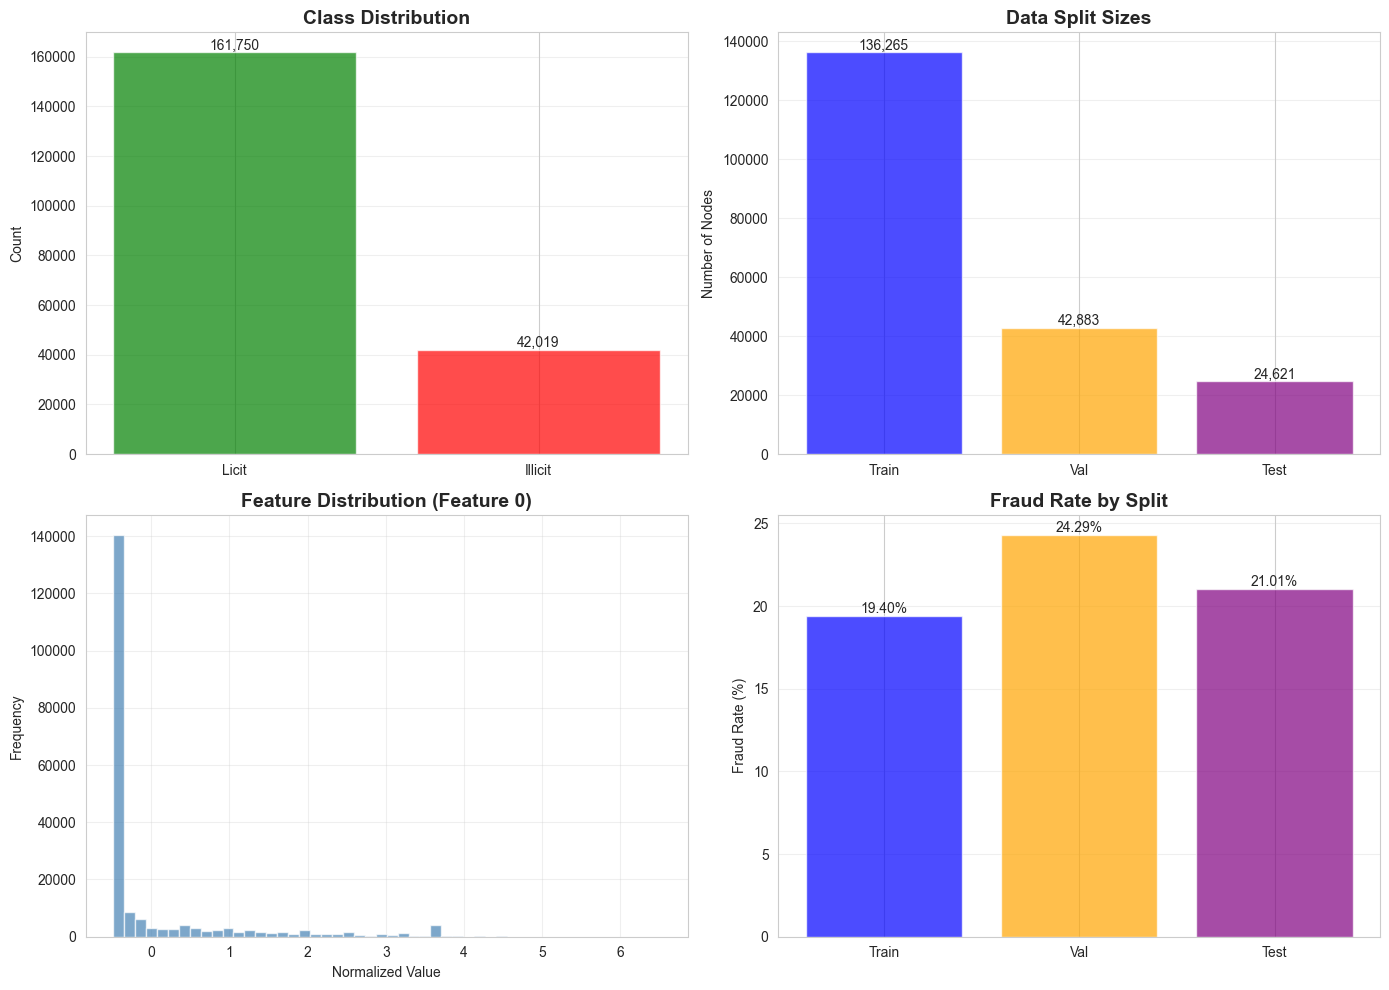


📈 Detailed Statistics:
   Total nodes: 203,769
   Total edges: 468,710
   Average degree: 2.30
   Feature dimension: 100

   Fraud rates:
      Train: 19.40%
      Val: 24.29%
      Test: 21.01%


In [6]:
# Visualize graph statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Class distribution
class_counts = pd.Series({
    'Licit': (graph_data.y == 0).sum().item(),
    'Illicit': (graph_data.y == 1).sum().item()
})
axes[0, 0].bar(class_counts.index, class_counts.values, color=['green', 'red'], alpha=0.7)
axes[0, 0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(class_counts.values):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom')

# 2. Split sizes
split_counts = pd.Series({
    'Train': graph_data.train_mask.sum().item(),
    'Val': graph_data.val_mask.sum().item(),
    'Test': graph_data.test_mask.sum().item()
})
axes[0, 1].bar(split_counts.index, split_counts.values, color=['blue', 'orange', 'purple'], alpha=0.7)
axes[0, 1].set_title('Data Split Sizes', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Number of Nodes')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(split_counts.values):
    axes[0, 1].text(i, v, f'{v:,}', ha='center', va='bottom')

# 3. Feature distribution (first feature)
axes[1, 0].hist(graph_data.x[:, 0].numpy(), bins=50, alpha=0.7, color='steelblue')
axes[1, 0].set_title('Feature Distribution (Feature 0)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Normalized Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# 4. Fraud rate by split
fraud_rates = pd.Series({
    'Train': graph_data.y[graph_data.train_mask].float().mean().item() * 100,
    'Val': graph_data.y[graph_data.val_mask].float().mean().item() * 100,
    'Test': graph_data.y[graph_data.test_mask].float().mean().item() * 100
})
axes[1, 1].bar(fraud_rates.index, fraud_rates.values, color=['blue', 'orange', 'purple'], alpha=0.7)
axes[1, 1].set_title('Fraud Rate by Split', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Fraud Rate (%)')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(fraud_rates.values):
    axes[1, 1].text(i, v, f'{v:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print('\n📈 Detailed Statistics:')
print(f'   Total nodes: {graph_data.num_nodes:,}')
print(f'   Total edges: {graph_data.edge_index.size(1):,}')
print(f'   Average degree: {graph_data.edge_index.size(1) / graph_data.num_nodes:.2f}')
print(f'   Feature dimension: {graph_data.num_features}')
print(f'\n   Fraud rates:')
for split in ['Train', 'Val', 'Test']:
    print(f'      {split}: {fraud_rates[split]:.2f}%')

In [7]:
# Save graph and all auxiliary files
builder.save_graph(filename='elliptic_graph_data.pt')

print('\n' + '='*70)
print('GRAPH CONSTRUCTION COMPLETE')
print('='*70)
print(f'\n✅ Graph ready for GNN training!')
print(f'   Location: {GRAPHS_PATH / "elliptic_graph_data.pt"}')
print(f'\n📝 Next steps:')
print('   1. Load graph: graph = torch.load("elliptic_graph_data.pt")')
print('   2. Train GNN models (see notebook 03)')
print('   3. Evaluate on temporal test set')
print('='*70)


💾 Saving graph...
   Graph saved: C:\Users\youss\Downloads\Flag_finance\data\graphs\elliptic_graph_data.pt
   Scaler saved: C:\Users\youss\Downloads\Flag_finance\data\graphs\feature_scaler.joblib
   ID mapping saved: C:\Users\youss\Downloads\Flag_finance\data\graphs\id2idx.json
   Metadata saved: C:\Users\youss\Downloads\Flag_finance\data\graphs\graph_metadata.json

✅ All files saved to: C:\Users\youss\Downloads\Flag_finance\data\graphs

GRAPH CONSTRUCTION COMPLETE

✅ Graph ready for GNN training!
   Location: C:\Users\youss\Downloads\Flag_finance\data\graphs\elliptic_graph_data.pt

📝 Next steps:
   1. Load graph: graph = torch.load("elliptic_graph_data.pt")
   2. Train GNN models (see notebook 03)
   3. Evaluate on temporal test set
